# Basics of a model : Simplified version of the U-Net architecture

We implement, using Pytorch, the U-Net architecture, that is very good at retaining information from an image. Originally introduced for the task of segmentation, it proved to be a very good image encoder, that can be used in more computer vision tasks. Today's Diffusion models are built on top of this architecture.

This is an implementation of the original architecture published in [this article](https://arxiv.org/pdf/1505.04597.pdf).

The U-Net architecture effectively encodes all of the main information about an image in a latent space.

## Implementing the architecture

We implement it in Pytorch.

In [3]:
import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as f

The UNet has two main parts. One is responsible for creating a features map of an image, so it encodes it in low dimension.

At each point, there is a double convolution of the representation of the image, first reducing it to lower resolution in the "contracting path" then expanding the size of the features representation in the "expanding path".

At each upsampling step in the expanding path, information from the previously encoded representation with the same dimension is concatened, helping retain information from when we were extracting features in the encoder.

This way, the network can form an encoding of both the high-resolution features of an image and its low-resolution features.

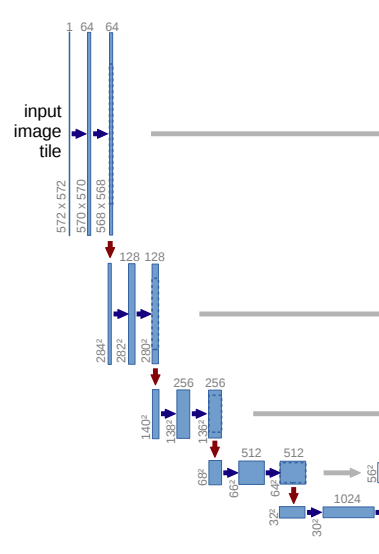

There is a succession of Double Convolutions layers each followed by a 2D Max Pooling layer. Let's write a function to automatically define each double layer given some in and out dimensions.

We pad the layers because we want the output image dimension to be the same as input. (not done in original paper)

In [4]:
def doublec(inch, outch):

    conv = nn.Sequential(
        nn.Conv2d(in_channels=inch, out_channels=outch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=outch, out_channels=outch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv

We will implement the architecture for a 572x572x3 image, like the example of the original paper.

Now we define the layers of the model and its forward function

In [32]:
class UNet(nn.Module):
   # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
   #Encoder
  def __init__(self, classes):
    super().__init__()

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layers=[doublec(3, 64)]
    in_channels=64
    out_channels=128
    for i in range(4):

            self.layers.append(doublec(in_channels, out_channels))
            in_channels*=2
            out_channels*=2

    in_channels=1024
    out_channels=512
    for i in range(4):
      print(in_channels)
      self.layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2))
      # we double the size of input channels here because we concatenate it with the according output in the contracting path
      self.layers.append(doublec(in_channels, out_channels))
      in_channels//=2
      out_channels//=2


    self.output=nn.Conv2d(in_channels=64, out_channels=classes, kernel_size=1)

  def forward(self, x):
      print(self.layers)
      #steps
      up=[self.layers[0](x)]
      up.append(self.maxpool(up[0]))
      for i in range(1,4):
        up.append(self.layers[i](up[-1]))
        up.append(self.maxpool(up[-1]))

      # forward last layer without applying maxpool to it
      up.append(self.layers[4](up[-1]))

      # follow the extending path, maintaining connections to the contracting path

      # steps of the decoder
      d1 = self.layers[5](up[-1])
      x = self.layers[6](torch.cat([up[6], d1], 1))
      d2 = self.layers[7](x)
      x = self.layers[8](torch.cat([up[4], d2], 1))
      d3 = self.layers[9](x)
      x = self.layers[10](torch.cat([up[2], d3], 1))
      d4 = self.layers[11](x)
      x = self.layers[12](torch.cat([up[0], d4], 1))

      out = self.output(x)

      return out

## Testing



Let'ts now feed forward a tensor, that could correspond to an input image, and check that after it passes through the network we obtain the desired sized vector

We haven't trained the network, so the output vector doesn't correspond to anything yet.

We can still see that the output size for (1, 3, 512, 512) input matches (1, 10, 512, 512) with 10 output classes.

In [33]:
input_image = torch.rand((1, 3, 512, 512))
model = UNet(10)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params} parameters to train.")
print("Quick overview of the layers of the model : ")
outputs = model(input_image)
print(outputs.shape)

1024
512
256
128
650 total parameters.
650 parameters to train.
[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
), Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
), Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
), Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
), Sequential(
  (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), p